## Artifical Intelligence Exercise 10   
### Question 2: Feature Learning and Sample Synthesis via Variational Auto-Encoder

In [19]:
from easydict import EasyDict as edict
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms

%matplotlib inline

#### Configurations

In [2]:
args = edict()
args.cuda = False
args.test_batch_size = 1000
args.batch_size = 128
args.lr = 0.001
args.momentum = 10**(-5)
args.log_interval = 100
args.epochs = 10

#### Functions and Classes

In [3]:
# Define the labels
labels_translation = {0: 'T-shirt,top',
              1: 'Trouser',
              2: 'Pullover',
              3: 'Dress',
              4: 'Coat',
              5: 'Sandal',
              6: 'Shirt',
              7: 'Sneaker',
              8: 'Bag',
              9: 'Ankle_boot'}

In [4]:
def to_img(x):
    """ Maps a 2D tensor from range [-1, 1] to 4D tensor with range [0, 1].
    Useful for plotting of reconstructions.

    :param x: 2D Tensor that is supposed to be converted
    :return: Converted 4D Tensor with b, c, w, h, where w = h = 28
    """
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [5]:
def show_image(image, label=None):
    plt.imshow(image, cmap='gray')
    if label is not None:
        plt.title(labels_translation[label])
    plt.show()

In [6]:
# VAE Loss
# recon_x: image reconstructions
# x: images
# mu and logvar: outputs of your encoder
# batch_size: batch_size
# img_size: width, respectively height of you images
# nc: number of image channels
def loss_function(recon_x, x, mu, logvar, batch_size, img_size, nc):
    MSE = F.mse_loss(recon_x, x.view(-1, img_size * img_size * nc))

    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Normalize
    KLD /= batch_size * img_size * img_size * nc

    return MSE + KLD

In [7]:
# Manifold approximation using tSNE
#
# features: (numpy array) N x D feature matrix
# images: (numpy array) N x H x W x 3
# path_save: string (path where you want to save the final image)
def apply_tnse_img(features, images, path_save='./tsne_img.png'):

    tnse = TSNE(n_components=2, init='pca', n_iter=1000, random_state=1254, perplexity=30, metric='euclidean')
    # np.set_printoptions(False)
    vis_data = tnse.fit_transform(features)
    vis_x = vis_data[:, 0]
    vis_y = vis_data[:, 1]

    # get max heigth, width
    max_width = max([image.shape[2] for image in images])
    max_height = max([image.shape[1] for image in images])

    # get max, min coords
    x_min, x_max = vis_x.min(), vis_x.max()
    y_min, y_max = vis_y.min(), vis_y.max()

    # Fix the ratios
    res = 700
    sx = (x_max - x_min)
    sy = (y_max - y_min)
    if sx > sy:
        res_x = int(sx / float(sy) * res)
        res_y = res
    else:
        res_x = res
        res_y = int(sy / float(sx) * res)

    # impaint images
    canvas = np.ones((res_x + max_width, res_y + max_height, 3))
    x_coords = np.linspace(x_min, x_max, res_x)
    y_coords = np.linspace(y_min, y_max, res_y)
    for x, y, image in zip(vis_x, vis_y, images):
        w, h = image.shape[:2]
        x_idx = np.argmin((x - x_coords) ** 2)
        y_idx = np.argmin((y - y_coords) ** 2)
        try:
            canvas[x_idx:x_idx + w, y_idx:y_idx + h] = image
        except:
            print('Image out of borders.... skip!')

    # plot image
    fig = plt.figure()
    plt.imshow(canvas)

    mng = plt.get_current_fig_manager()
    mng.full_screen_toggle()
    plt.show(False)
    plt.pause(3)
    fig.savefig(path_save, bbox_inches='tight')

In [8]:
class VarAutoencoder(nn.Module):

    def __init__(self, H, W, Nc):
        super(VarAutoencoder, self).__init__()
        
        # Encoder part
        self.fc11 = nn.Linear(in_features = H*W*Nc, out_features = 512)
        self.r11 = nn.ReLU(inplace=True)
        self.fc12 = nn.Linear(in_features = 512, out_features = 256)
        self.r12 = nn.ReLU(inplace=True)
        self.f13 = nn.Linear(in_features = 256, out_features = 64) # mu layer
        self.f14 = nn.Linear(in_features = 256, out_features = 64) # logvariance layer
        
        # Decoder part
        self.fc21 = nn.Linear(in_features = 64, out_features = 256)
        self.r21 = nn.ReLU(inplace=True)
        self.fc22 = nn.Linear(in_features = 256, out_features = 512)
        self.r22 = nn.ReLU(inplace=True)
        self.fc23 = nn.Linear(in_features = 512, out_features = H*W*Nc)
        self.t = nn.Tanh()        
    
    def encoder(self, x):
        hidden = self.r12(self.fc12(self.r11(self.fc11(x))))
        mu = self.f13(hidden)
        logvar = self.f14(hidden)
        return mu, logvar
    
    # Reparametrization trick for training VAEs
    # mu and logvar: output of your encoder
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decoder(self, x):
        res = self.t(self.fc23(self.r22(self.fc22(self.r21(self.fc21(x))))))
        return res
        
    def forward(self, x):
        # Get mu and logvar from the encoder and apply the reparametrization trick
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)        
        # Apply the decoder to generate new images
        res = self.decoder(z)
        return res, mu, logvar

In [9]:
# Training loop (one epoch)
def train(model, epoch, img_size, Nc):
    model.train()
    train_loss = 0.0 # compute total loss over one epoch
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0), -1)
        if args.cuda:
            data, target = data.cuda(), target.cuda()   
        data, target = Variable(data), Variable(target)
        
        optimizer.zero_grad()
        output, mu, logvar = model(data) # forward pass through the network
        loss = loss_function(output, data, mu, logvar, args.batch_size, img_size, Nc)
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
    
    # Plot ten images plus reconstructions and 10 generated images
    if epoch in [1,5,10]:
        true_img = data.data[0:11].numpy()
        reconstructed = to_img(model.decoder(mu)) # give mu into the decoder to reconstruct the image
        reconstructed_img = reconstructed.data[0:11].numpy()
        generated = to_img(output) # the output are the generated data
        generated_img = generated.data[0:11].numpy()

        fig, axes = plt.subplots(10, 3)
        plt.suptitle('Epoch %i: left - original images; middle - reconstructed images, right - generated images' %(epoch))
        for i in range(1, 11):
            axes[i-1][0].imshow(true_img[i-1].reshape((28, 28)), cmap=plt.cm.Greys_r)
            axes[i-1][1].imshow(reconstructed_img[i-1].reshape((28, 28)), cmap=plt.cm.Greys_r)
            axes[i-1][2].imshow(generated_img[i-1].reshape((28, 28)), cmap=plt.cm.Greys_r)
        plt.savefig('Epoch %i' %(epoch))

    print('Total loss over epoch %s: %s' %(epoch, train_loss/len(train_loader.dataset)))

#### Data Preparation

In [10]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data09_2', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data09_2', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.test_batch_size, shuffle=False)

Processing...
Done!


#### Training

In [11]:
# create the autoencoder and move to GPU if available
H, W, img_size, Nc = 28,28,28,1
var_autoencoder = VarAutoencoder(H, W, Nc)
if args.cuda:
    var_autoencoder.cuda()

In [12]:
# initialize the optimzation algorithm
optimizer = torch.optim.Adam(var_autoencoder.parameters(), lr=args.lr, eps=args.momentum)

Total loss over epoch 1: 0.0005192597617084781
Total loss over epoch 2: 0.00045211628042161466
Total loss over epoch 3: 0.0003936624531323711
Total loss over epoch 4: 0.00036766339285920064
Total loss over epoch 5: 0.00035288780108094217
Total loss over epoch 6: 0.0003447502178450426
Total loss over epoch 7: 0.0003387023964896798
Total loss over epoch 8: 0.00033386255794515214
Total loss over epoch 9: 0.0003299685937662919
Total loss over epoch 10: 0.00032546195394049087


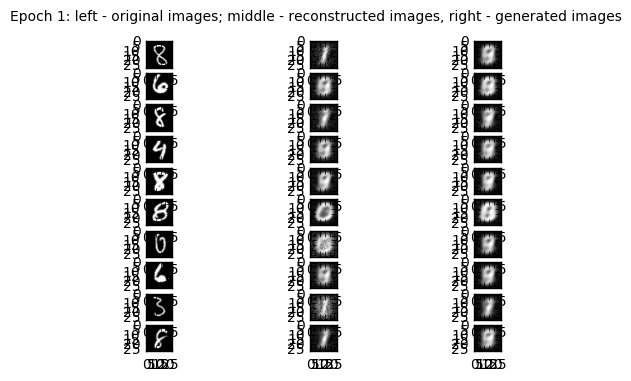

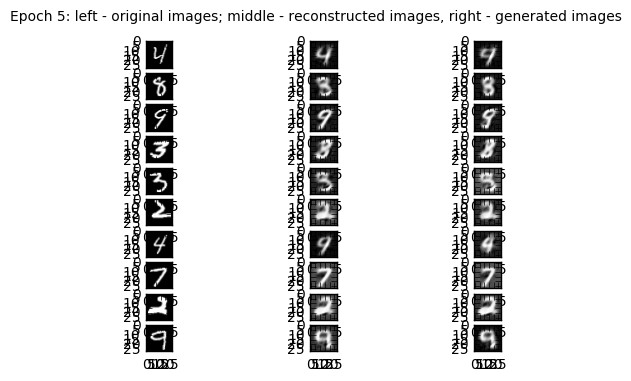

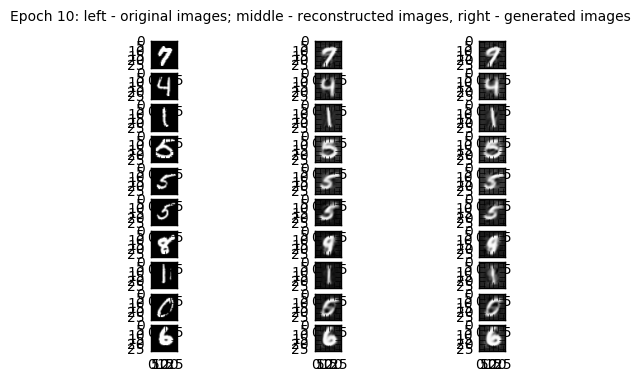

In [13]:
# Train the variational autoencoder
for epoch in range(1,11):
    train(var_autoencoder, epoch, img_size, Nc)

#### Extracting features 

In [14]:
# create a data loader to get 400 images from the test set
test_loader_400 = torch.utils.data.DataLoader(
    datasets.MNIST('./data09_2', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.batch_size, shuffle=False)

In [15]:
def get_features(data_loader, model):
    # Get 500 images and retrieve their representation from the net
    data, _ = next(iter(data_loader))
    data = data.view(data.size(0), -1)
    data = Variable(data)

    if args.cuda:
        data = data.cuda()

    # get the features from the autoencoder
    mu, _ = model.encoder(data)
    
    # Transform the features (= mu) to numpy
    mu = mu.data.cpu().numpy()    
    return mu
    
feat = get_features(test_loader_400, var_autoencoder)
print(feat.shape)

(128, 64)


Cluster center Nr. 0


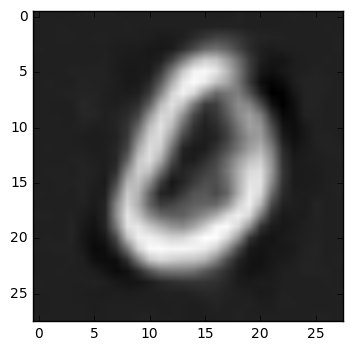

Cluster center Nr. 1


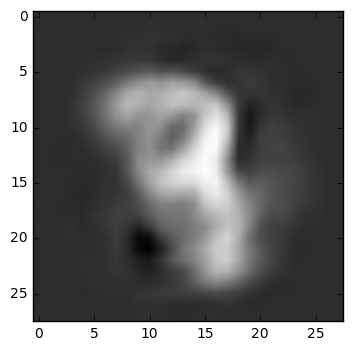

Cluster center Nr. 2


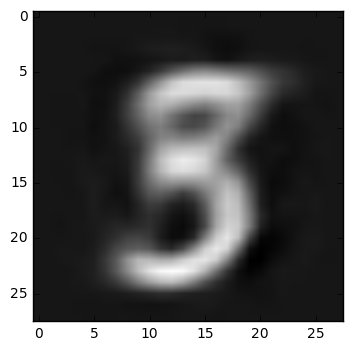

Cluster center Nr. 3


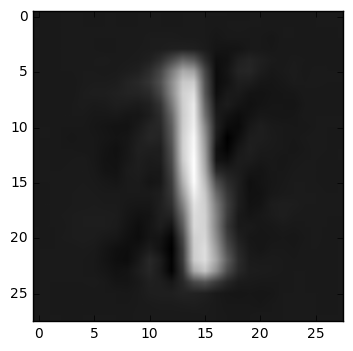

Cluster center Nr. 4


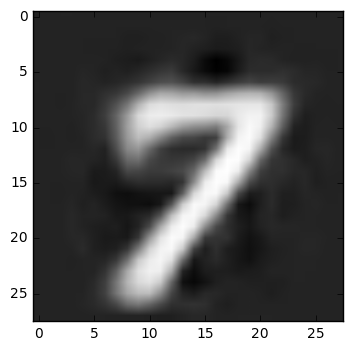

Cluster center Nr. 5


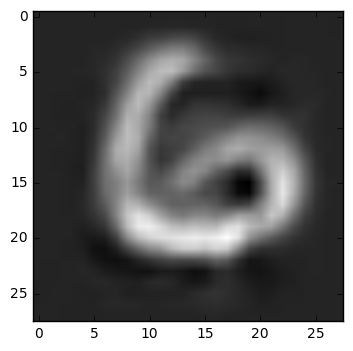

Cluster center Nr. 6


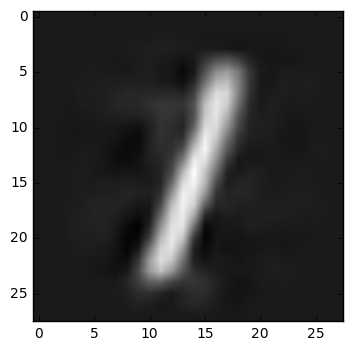

Cluster center Nr. 7


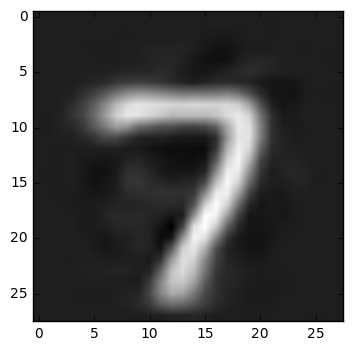

Cluster center Nr. 8


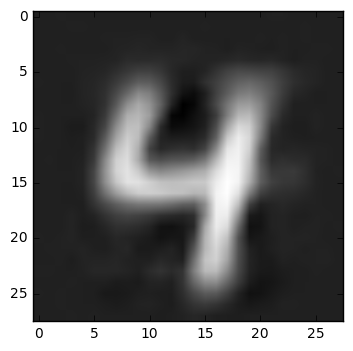

Cluster center Nr. 9


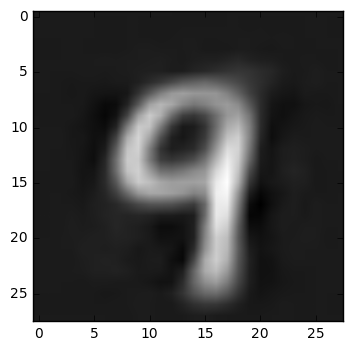

In [20]:
# Apply k-means algorithm to the features
kmeans = KMeans(n_clusters=10).fit(feat)
centers = kmeans.cluster_centers_

# Visualize cluster centers respectively their corresponding images (every row is a cluster center = cluster-center image)
centers = Variable(torch.from_numpy(centers)) # convert to pytorch Variable
output = var_autoencoder.decoder(centers.type('torch.FloatTensor')) # apply decoder to generate image
images = to_img(output) # convert to an image
images = images.data.numpy() # convert image data to numpy

for i in range(10):
    print('Cluster center Nr.', i)
    show_image(images[i].reshape((28, 28)))

(10, 1, 28, 28) (128, 64)
Image out of borders.... skip!
Image out of borders.... skip!
Image out of borders.... skip!


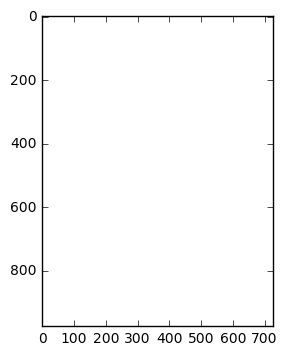

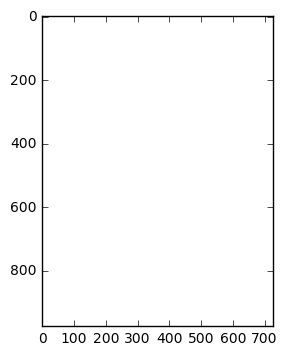

In [21]:
print(images.shape, feat.shape)
apply_tnse_img(feat, images[:3])